In [1]:
# Menambahkan path direktori Kode_Skripsi untuk mengimpor file functions.py
import sys
sys.path.append('/content/drive/MyDrive/Kode_Skripsi')

In [2]:
!cp /content/drive/MyDrive/Kode_Skripsi/functions.py /content/

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, roc_auc_score,log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import copy
import functions
import os
import joblib

In [4]:
# Mengabaikan warning penggunaan processor dan konfigurasi penggunaan weight terbaik dari epoch sebelumnya
functions.ignore_warnings()

In [5]:
# Mengambil dataset CIC IoT DIAD
ciciotdiad_6classes = '/content/drive/MyDrive/Dataset_Skripsi/6_Classes/CIC-IoT-IDAD_6Classes.csv'
df = pd.read_csv(ciciotdiad_6classes)

# Memisahkan kolom fitur dan target
X = df.drop(columns=['Label'])
y = df['Label']

In [6]:
# Menyimpan label asli sebelum encoding agar tidak ikut termodifikasi
y_label = y.copy()

# Melakukan encoding label utama (y) sekali untuk StratifiedKFold
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y.squeeze())

In [7]:
# Menampilkan hasil encoding
functions.show_label_encoding(y, y_encoded)

===== Mapping Label Encoding (Attack_type) =====
    Label_Original  Label_Encoded
   DDoS-HTTP_Flood              0
    DoS-HTTP_Flood              1
     DoS-UDP_Flood              2
Mirai-greeth_flood              3
      SqlInjection              4
               XSS              5


#XGBoost

In [8]:
# Melakukan Stratified K-Fold dengan 5 fold dan hasilnya diacak
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Memastikan folder Model_Skripsi tersedia
os.makedirs("/content/drive/MyDrive/Model_Skripsi/", exist_ok=True)

In [10]:
# Melakukan inisialisasi untuk menyimpan kurva metrik per epoch dalam setiap fold
fold_logloss_curve = []
fold_accuracy_curve = []

# Melakukan inisialisasi untuk nantinya menyimpan metrik setiap fold
fold_results = {
    'fold': [],
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'roc_auc': [],
    'log_loss': []
}
evals_result = {}

# Melakukan inisialisasi model terbaik
best_model = None

best_logloss = float('inf')
best_preds = None
best_y_true = None
best_fold = -1

# Melakukan inisialisasi untuk nilai epoch dan patience yang sedang digunakan
n_epochs = 100
n_earlystop = 15

# Melakukan Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded)):
    eval_result_this_fold = {}
    print(f"\nFold {fold+1}")


    # Melakukan split data
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Melakukan encoding dan scaling
    y_train_enc = label_encoder_y.fit_transform(y_train)
    y_test_enc = label_encoder_y.transform(y_test)


    X_train_np, X_test_np = functions.encoding_cic_iot_diad_6classes(X_train, X_test)


    y_train_np = np.array(y_train_enc, dtype=np.int64)
    y_test_np = np.array(y_test_enc, dtype=np.int64)

    # Menggunakan compute class weights untuk bobot balancing dataset
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_np),
        y=y_train_np
    )
    sample_weights = class_weights[y_train_np]

    # Membuat DMatrix
    dtrain = xgb.DMatrix(X_train_np, label=y_train_np, weight=sample_weights)
    dvalid = xgb.DMatrix(X_test_np, label=y_test_np)

    # Menentukan parameter XGBoost yang digunakan
    params = {
        "objective": "multi:softprob",
        "num_class": len(np.unique(y_train_np)),
        "eval_metric": ["mlogloss", "merror"],
        "eta": 0.1,
        "seed": 42,
        "verbosity": 1,
    }

    # Melakukan training model
    evals = [(dvalid, "eval"), (dtrain, "train")]

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=50,
        evals=evals,
        evals_result=eval_result_this_fold,
        early_stopping_rounds=10,
        verbose_eval=True
    )

    # Menyimpan kurva logloss dari fold ini
    fold_logloss_curve.append(copy.deepcopy(eval_result_this_fold['eval']['mlogloss']))

    # Mengonversi merror menjadi accuracy = 1 - merror
    eval_accuracy = [1.0 - e for e in eval_result_this_fold['eval']['merror']]
    fold_accuracy_curve.append(eval_accuracy)

    # Melakukan evaluasi pada metrik accuracy, F1-score, dan precision
    pred_proba = booster.predict(dvalid)
    preds = np.argmax(pred_proba, axis=1)


    acc = accuracy_score(y_test_np, preds)
    f1 = f1_score(y_test_np, preds, average='macro')
    precision = precision_score(y_test_np, preds, average='macro')
    logloss = log_loss(y_test_np, pred_proba)

    # Menghitung multiclass AUC-ROC
    try:
        auc = roc_auc_score(y_test_np, pred_proba, multi_class='ovr', average='macro')
    except:
        auc = None

    if logloss < best_logloss:
        best_logloss = logloss
        best_model = booster
        best_preds = preds
        best_y_true = y_test_np
        best_fold = fold + 1

    print(f"Fold {fold+1} Metrics:")
    print(f"Accuracy: {acc:.6f}, F1: {f1:.6f}, Precision: {precision:.6f}, LogLoss: {logloss:.6f}, AUC: {auc:.6f}")


    # Menyimpan semua nilai metrik ke dictionary hasil
    fold_results['fold'].append(fold + 1)
    fold_results['accuracy'].append(acc)
    fold_results['f1_score'].append(f1)
    fold_results['precision'].append(precision)
    fold_results['roc_auc'].append(auc)
    fold_results['log_loss'].append(logloss)


Fold 1
[0]	eval-mlogloss:1.59660	eval-merror:0.07092	train-mlogloss:1.50254	train-merror:0.00068
[1]	eval-mlogloss:1.40483	eval-merror:0.07370	train-mlogloss:1.28990	train-merror:0.00061
[2]	eval-mlogloss:1.25400	eval-merror:0.07361	train-mlogloss:1.12242	train-merror:0.00060
[3]	eval-mlogloss:1.12716	eval-merror:0.07361	train-mlogloss:0.98526	train-merror:0.00052
[4]	eval-mlogloss:1.02133	eval-merror:0.07259	train-mlogloss:0.87017	train-merror:0.00050
[5]	eval-mlogloss:0.93152	eval-merror:0.07259	train-mlogloss:0.77203	train-merror:0.00053
[6]	eval-mlogloss:0.85446	eval-merror:0.07259	train-mlogloss:0.68732	train-merror:0.00047
[7]	eval-mlogloss:0.78786	eval-merror:0.07259	train-mlogloss:0.61356	train-merror:0.00045
[8]	eval-mlogloss:0.72997	eval-merror:0.07259	train-mlogloss:0.54888	train-merror:0.00042
[9]	eval-mlogloss:0.67941	eval-merror:0.07110	train-mlogloss:0.49188	train-merror:0.00042
[10]	eval-mlogloss:0.63521	eval-merror:0.07101	train-mlogloss:0.44141	train-merror:0.00042
[

In [11]:
# Menyimpan model terbaik pada database
if best_model is not None:
    if n_epochs == 100 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_100/CIC-IoT-DIAD_xgb_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"
    elif n_epochs == 50 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_50/CIC-IoT-DIAD_xgb_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"


    joblib.dump(best_model, best_model_path)
    print(f"Model terbaik disimpan dari Fold {best_fold} dengan logloss: {best_logloss:.6f}")
    print(f"Model disimpan di path: {best_model_path}")

Model terbaik disimpan dari Fold 1 dengan logloss: 0.338901
Model disimpan di path: /content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_100/CIC-IoT-DIAD_xgb_best_model_fold1_logloss0.338901.pkl


## Evaluasi Logloss dan Accuracy

In [ ]:
# Melakukan print nilai logloss per epoch dari setiap fold
for i, curve in enumerate(fold_logloss_curve):
    print(f"Fold {i+1}: {len(curve)} epochs")
    print(f"LogLoss: {curve[:5]} ... {curve[-5:]}\n")


In [ ]:
# Melakukan print nilai logloss per epoch dari setiap fold
for i, curve in enumerate(fold_accuracy_curve):
    print(f"Fold {i+1}: {len(curve)} epochs")
    print(f"Accuracy: {curve[:5]} ... {curve[-5:]}\n")


## Grafik Logloss

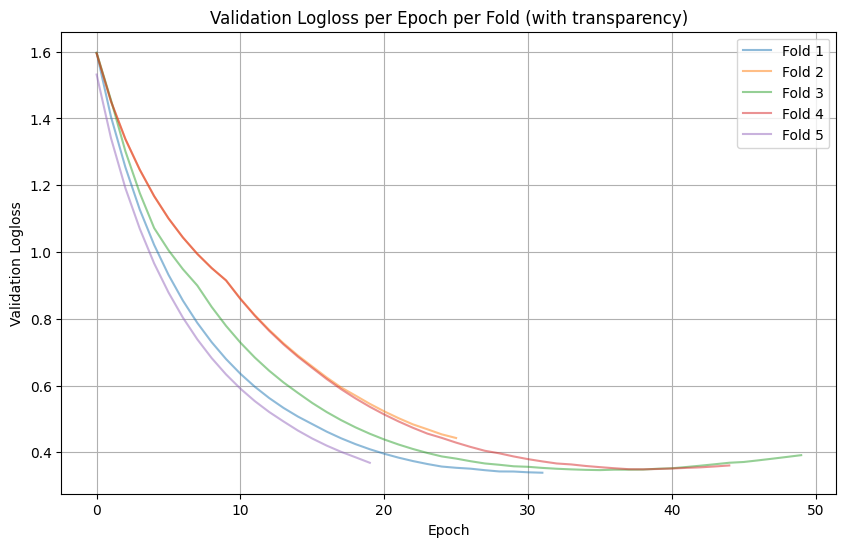

In [12]:
# Melakukan visualisasi grafik validation logLoss per epoch per Fold dengan visualisasi transparan pada setiap kurvanya agar semua kurva terlihat
functions.plot_curve_transparent(fold_logloss_curve, metric_name="Validation Logloss")

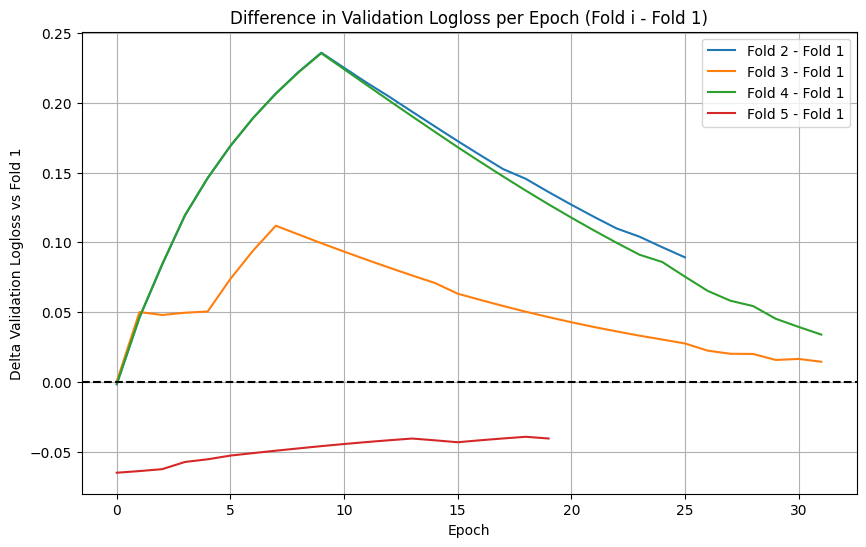

In [13]:
# Menampilkan visualisasi perbedaan logloss per epoch
functions.plot_curve_deltas(fold_logloss_curve, metric_name="Validation Logloss")

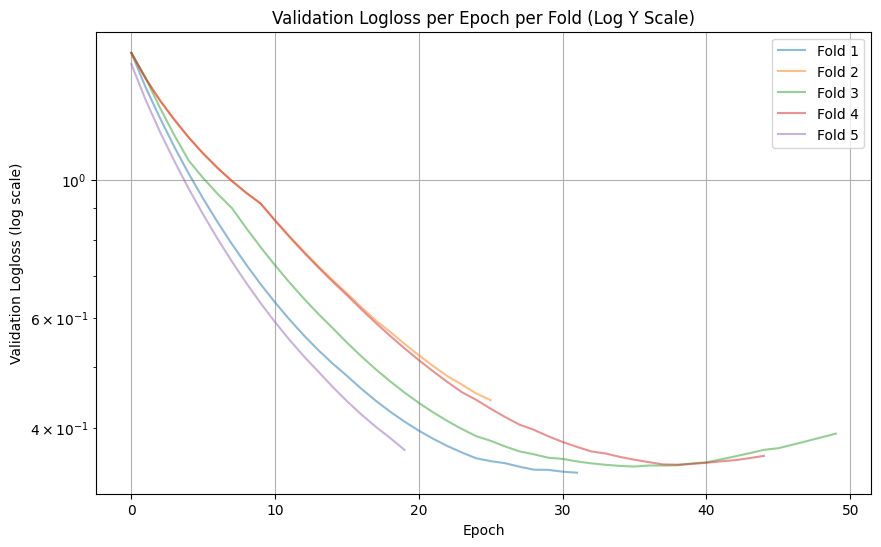

In [14]:
# Menampilkan visualisasi log gamma-scale agar visualisasi antar kurva lebih terlihat
functions.plot_curve_logscale(fold_logloss_curve, metric_name="Validation Logloss")

## Grafik Accuracy

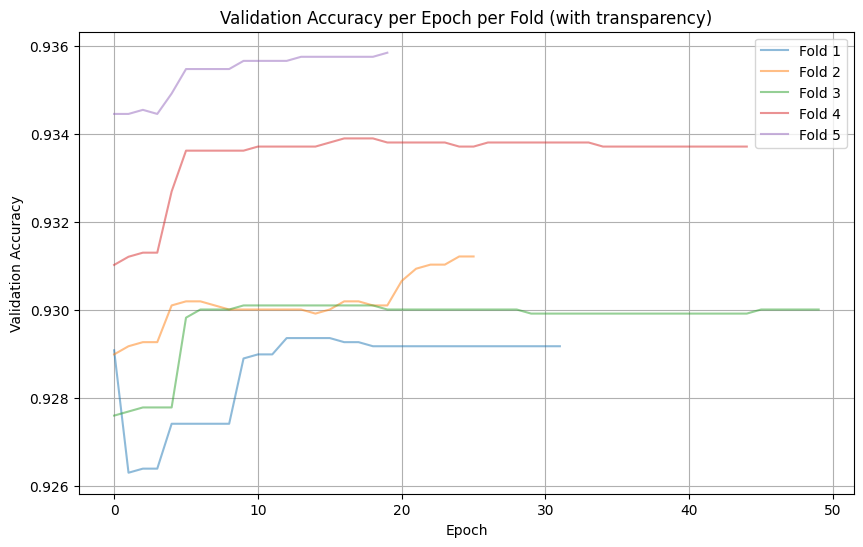

In [15]:
# Melakukan visualisasi grafik validation accuracy per epoch per Fold dengan visualisasi transparan pada setiap kurvanya agar semua kurva terlihat
functions.plot_curve_transparent(fold_accuracy_curve, metric_name="Validation Accuracy")

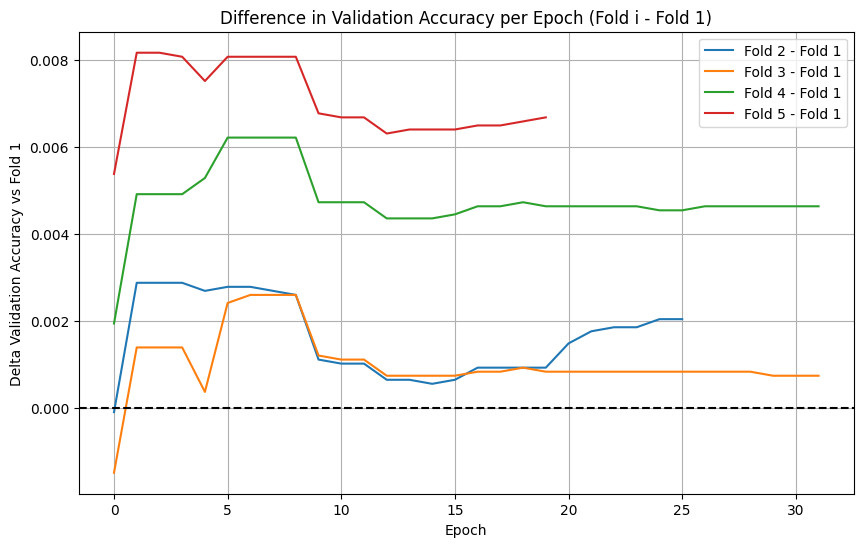

In [16]:
# Menampilkan visualisasi perbedaan logloss per epoch
functions.plot_curve_deltas(fold_accuracy_curve, metric_name="Validation Accuracy")

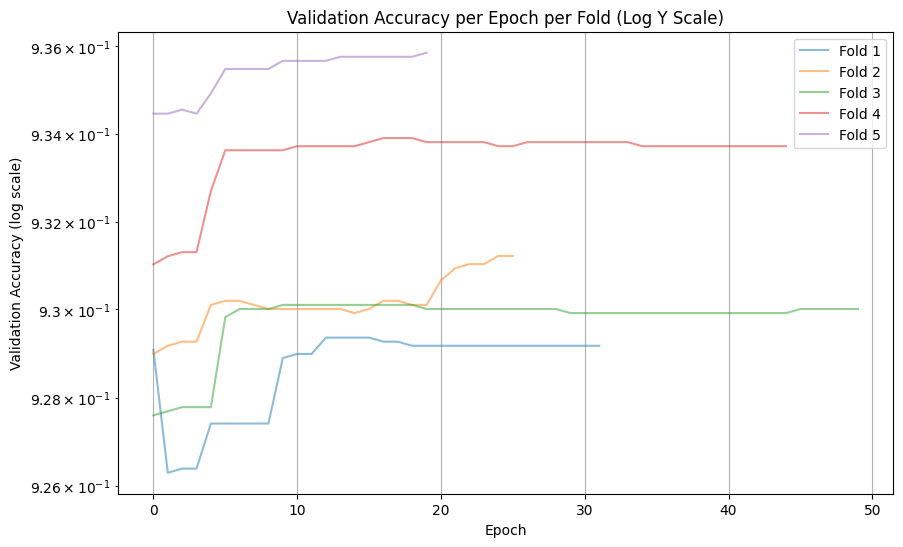

In [17]:
# Menampilkan visualisasi log gamma-scale agar visualisasi antar kurva lebih terlihat
functions.plot_curve_logscale(fold_accuracy_curve, metric_name="Validation Accuracy")

## Rangkuman Hasil

In [18]:
# Rangkuman hasil metrik setiap fold
results_df = pd.DataFrame(fold_results)
print("\n===== K-Fold Summary =====")
print(results_df)


===== K-Fold Summary =====
   fold  accuracy  f1_score  precision   roc_auc  log_loss
0     1  0.929175  0.926049   0.938473  0.968653  0.338901
1     2  0.931217  0.926987   0.939786  0.959216  0.442894
2     3  0.930010  0.925561   0.938468  0.964952  0.391506
3     4  0.933717  0.929614   0.940771  0.967478  0.360640
4     5  0.935852  0.931848   0.942351  0.977805  0.368640


In [19]:
# Menampilkan rata-rata semua metrik dari semua fold
print("\nMean Metrics:")
print(results_df.drop(columns='fold').mean())


Mean Metrics:
accuracy     0.931994
f1_score     0.928012
precision    0.939970
roc_auc      0.967621
log_loss     0.380516
dtype: float64


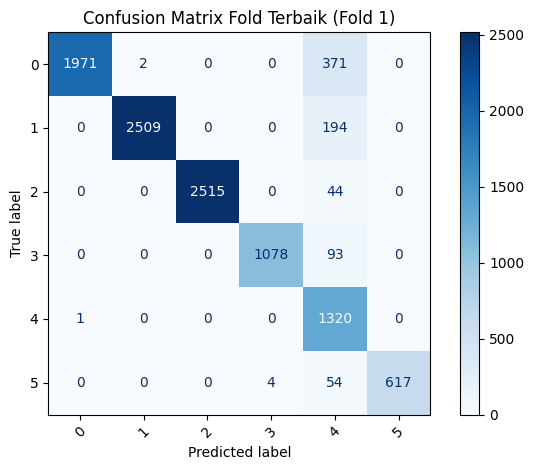

In [20]:
# Menampilkan visualisasi keakuratan prediksi model
functions.plot_best_confusion_matrix(best_y_true, best_preds, best_fold)